In [1]:
import os
from sklearn.model_selection import train_test_split
import cv2  
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def preprocess_image(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    lab_img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    a_channel = lab_img[:, :, 1]

    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    equalized_a_channel = clahe.apply(a_channel)

    kernel = np.ones((3, 3), np.uint8)
    dilated_img = cv2.dilate(equalized_a_channel, kernel, iterations=1)

    _, thresholded_img = cv2.threshold(dilated_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    return thresholded_img  

In [3]:
def load_images_from_folder(folder, target_size=(256, 256), test_size=0.2):
    images = []
    labels = []

    for label, class_folder in enumerate(os.listdir(folder)):
        class_path = os.path.join(folder, class_folder)
        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)
            img = cv2.imread(img_path)
            
            if img is not None:
                img = cv2.resize(img, target_size)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                preprocessed_img = preprocess_image(img)
                images.append(preprocessed_img)
                labels.append(label)

    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=test_size, random_state=42)

    return X_train, X_test, y_train, y_test

In [4]:
folder_path = 'C:\SUDHARSHAN\miniProject\RiceBioS_Dataset'
X_train, X_test, y_train, y_test = load_images_from_folder(folder_path)



In [5]:
# Convert to numpy arrays for further processing
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Check the shapes of the resulting arrays
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (840, 256, 256)
X_test shape: (210, 256, 256)
y_train shape: (840,)
y_test shape: (210,)


In [6]:
# Check the sizes of the sets
print(f"Train set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Train set size: 840
Test set size: 210


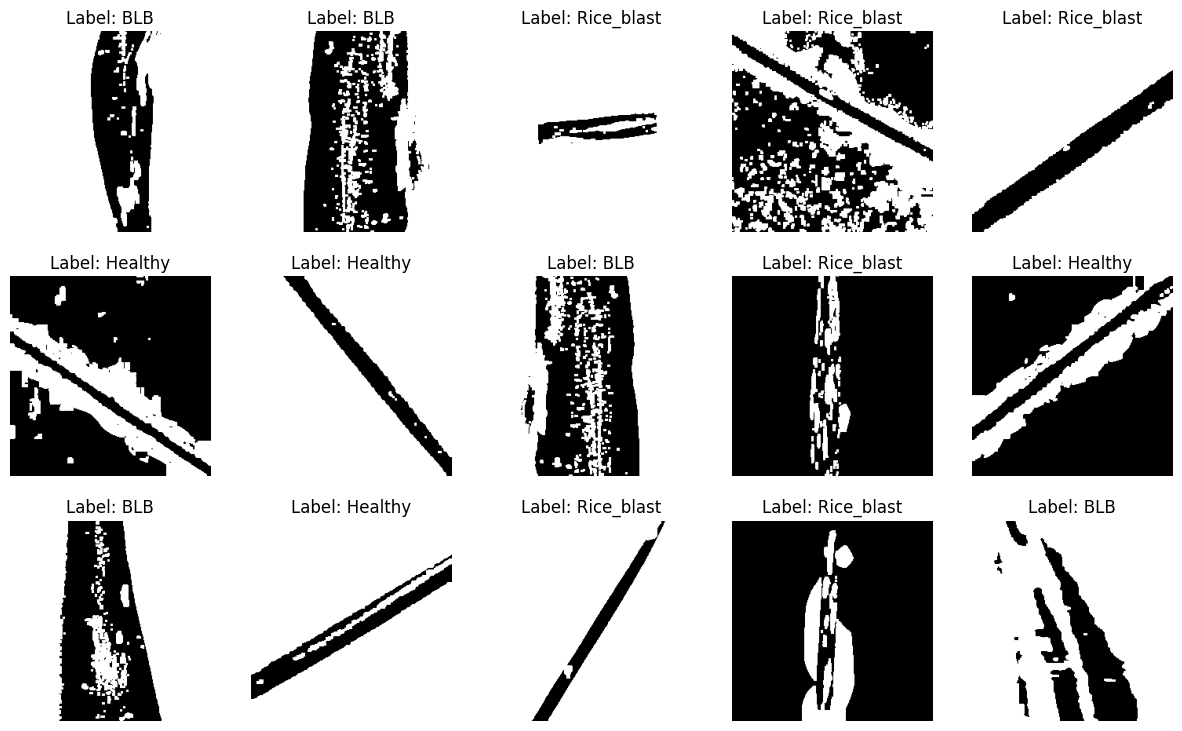

In [7]:
import matplotlib.pyplot as plt

# Assuming you have X_train, y_train from the previous code snippet
mappings={0:"Healthy",1:"Rice_blast",2:"BLB"}
# Define a function to visualize images with labels
def visualize_images(images, labels):
    fig, axes = plt.subplots(3, 5, figsize=(15, 9))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i],cmap='gray' if i != -1 else 'viridis')
        ax.set_title(f"Label: {mappings[labels[i]]}")
        ax.axis('off')
    plt.show()

# Visualize a subset of the training data
visualize_images(X_train[15:30], y_train[15:30])


In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the CNN model
model = models.Sequential()

# Convolutional Layer 1
model.add(layers.Conv2D(256, (3, 3), activation='relu', input_shape=(256, 256, 1)))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))

# Convolutional Layer 2
model.add(layers.Conv2D(85, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))

# Flatten layer
model.add(layers.Flatten())

# Dense Layer 1
model.add(layers.Dense(42, activation='relu'))

# Fully Connected Layer (Output Layer)
model.add(layers.Dense(3, activation='softmax'))

# Display the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 256)     2560      
                                                                 
 activation (Activation)     (None, 254, 254, 256)     0         
                                                                 
 batch_normalization (Batch  (None, 254, 254, 256)     1024      
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 256)     0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 127, 127, 256)     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 85)      1

In [9]:
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoding
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

# Compile the model with accuracy metric
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using your preprocessed images and one-hot encoded labels
RiceBiosModel = model.fit(X_train, y_train_one_hot, epochs=100, batch_size=32, validation_data=(X_test, y_test_one_hot))

# Get the final training and validation accuracy
training_accuracy = RiceBiosModel.history['accuracy'][-1]
validation_accuracy = RiceBiosModel.history['val_accuracy'][-1]

print("Training Accuracy:", training_accuracy)
print("Validation Accuracy:", validation_accuracy)


Epoch 1/100
27/27 [==============================] - 281s 10s/step - loss: 8.3483 - accuracy: 0.4405 - val_loss: 65.7934 - val_accuracy: 0.3238
Epoch 2/100
27/27 [==============================] - 261s 10s/step - loss: 1.0786 - accuracy: 0.6012 - val_loss: 36.6683 - val_accuracy: 0.3857
Epoch 3/100
27/27 [==============================] - 261s 10s/step - loss: 0.9518 - accuracy: 0.6917 - val_loss: 10.2219 - val_accuracy: 0.3476
Epoch 4/100
27/27 [==============================] - 259s 10s/step - loss: 0.7636 - accuracy: 0.7298 - val_loss: 1.2910 - val_accuracy: 0.5238
Epoch 5/100
27/27 [==============================] - 256s 10s/step - loss: 0.6501 - accuracy: 0.7857 - val_loss: 1.2255 - val_accuracy: 0.5762
Epoch 6/100
27/27 [==============================] - 256s 10s/step - loss: 0.5985 - accuracy: 0.8190 - val_loss: 1.4329 - val_accuracy: 0.5905
Epoch 7/100
27/27 [==============================] - 256s 9s/step - loss: 0.5739 - accuracy: 0.8143 - val_loss: 1.1383 - val_accuracy: 0.63